In [1]:
#pip install editdistance transformers 

In [2]:
import glob
from collections import defaultdict
from editdistance import eval as edist
from tokenizers import BertWordPieceTokenizer
import numpy as np
import editdistance
from tqdm.notebook import tqdm
import sys
from typing import List, Tuple
import torch
import pylelemmatize
import glob
import string
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

NBTOKENS = 6000

In [3]:
corpus_str = '\n'.join(['\t'.join([l.strip() for l in open(f,"r").readlines() if len(l.strip())>0]) for f in glob.glob("../../tmp/koeningsfelden/koenigsfelden_1308-1662_expanded/U-17*txt")])

In [4]:
def string_edit_distances(seq1: str, seq2: str, tokenizer:BertWordPieceTokenizer) -> int:
    #t = time.time()
    if len(seq1) * len(seq2) > 400**2:
        print(f"Strings to large {len(seq1)} {len(seq2)} dropping!")
        return (0, 0), (0, 0)
    num_seq1 = tokenizer.encode(seq1).ids
    num_seq2 = tokenizer.encode(seq2).ids
    num_dist = editdistance.eval(num_seq1, num_seq2)
    str_dist = editdistance.eval(seq1, seq2)
    num_len = max(len(num_seq1), len(num_seq2))
    str_len = max(len(seq1), len(seq2))
    if num_len == 0:
        num_len = 1
    if str_len == 0:
        str_len = 1
    #if (time.time() - t) > .001:
    #    print(f"Lasted long {time.time() - t} lengths: {len(seq1)} {len(seq2)}")
    #else:
    #    print(".", end="")
    return (num_dist, num_len), (str_dist, str_len)


def count_parallel_corpus_errors(parallel_corpus_str: List[Tuple[List[str], List[str]]], tokenizer: BertWordPieceTokenizer) -> Tuple[Tuple[int, int], Tuple[int, int]]: 
    num_counts = []
    num_lengths = []
    str_counts = []
    str_lengths = []
    with tqdm(total=len(parallel_corpus_str), desc='Document pairs') as progress:
        for doc_n, (doc1, doc2) in enumerate(parallel_corpus_str):
            for n in range(len(doc1)):
                line1, line2 = doc1[n], doc2[n]        
                (num_count, num_len), (str_count, str_len) = string_edit_distances(line1, line2, tokenizer=tokenizer)
                num_counts.append(num_count)
                num_lengths.append(num_len)
                str_counts.append(str_count)
                str_lengths.append(str_len)
            progress.update(1)
    num_counts = np.array(num_counts)
    num_lengths = np.array(num_lengths)
    str_counts = np.array(str_counts)
    str_lengths = np.array(str_lengths)
    num_counts = num_counts.sum()
    num_lengths = num_lengths.sum()
    str_counts = str_counts.sum()
    str_lengths = str_lengths.sum()
    print(f"Tokens: {100*num_counts/num_lengths:.2f}% @{num_lengths},  CER:{100*str_counts/str_lengths:.2f} @ {str_lengths}")
    return (num_counts, num_lengths), (str_counts, str_lengths)

def get_cer_table(corpus_str, mapper_list,mapper_names):
    tbl = np.zeros([len(mapper_list), len(mapper_list)])
    corpora = [mapper(corpus_str) for mapper in mapper_list]
    for row_n in range(len(mapper_list)):
        for col_n in range(len(mapper_list)):
            d = 100 * pylelemmatize.fast_cer(corpora[row_n], corpora[col_n])
            tbl[row_n, col_n]=d
            tbl[col_n, row_n]=d
    df = pd.DataFrame(tbl, index=mapper_names, columns=mapper_names)
    return df


def str_to_corpus(corpus_str):
    corpus = [c.strip() for c in corpus_str.split("\n") if c.strip()]
    corpus = [[l.strip() for l in d.split('\t') if l.strip()] for d in corpus]
    return corpus


def create_tokenizers(corpus_str, mappers=[], mappernames=[], vocab_size=30000):
    if mappers == [] and mappernames == []:
        mappers = [lambda x:x]
        mappernames = ['original']
    tokenizers = []
    for mapper,mapname in zip(mappers, mappernames):
        mapper_corpus_str = mapper(corpus_str)
        mapper_corpus_filename = f"./corpus_{mapname}.txt"
        open(mapper_corpus_filename,"w").write(mapper_corpus_str.replace("\t","\n"))
        tokenizer = BertWordPieceTokenizer()
        tokenizer.train(files=[mapper_corpus_filename], vocab_size=vocab_size)
        tokenizers.append(tokenizer)
    return tokenizers


def tokenization_distance(corpus_str, mapper1, mapper2, tokenizer):
    str1 = mapper1(corpus_str)
    str1 = [l.strip() for l in str1.replace("\t", "\n").split("\n") if l.strip()]
    str2 = mapper2(corpus_str)
    str2 = [l.strip() for l in str2.replace("\t", "\n").split("\n") if l.strip()]
    #print(f"Distance #1 {len(str1)} #2 {len(str2)} ")
    num_counts = []
    num_lengths = []
    str_counts = []
    str_lengths = []
    for n, (seq1, seq2) in enumerate(zip(str1, str2)):
        num_seq1 = tokenizer.encode(seq1).ids
        num_seq2 = tokenizer.encode(seq2).ids
        num_dist = editdistance.eval(num_seq1, num_seq2)
        str_dist = editdistance.eval(seq1, seq2)
        num_len = max(len(num_seq1), len(num_seq2))
        str_len = max(len(seq1), len(seq2))
        #if n == 3:
        #    print(f"seq1: {repr(seq1)}\nseq2: {repr(seq2)}\nnum1: {num_seq1}\nnum2: {num_seq2}\num_dist{num_dist}\nstr_dist: {str_dist}")
        if num_len == 0:
            num_len = 1
        if str_len == 0:
            str_len = 1
        num_counts.append(num_dist)
        num_lengths.append(max(len(num_seq1),len(num_seq2)))
        str_counts.append(str_dist)
        str_lengths.append(len(seq1))
    num_counts = np.array(num_counts)
    num_lengths = np.array(num_lengths)
    str_counts = np.array(str_counts)
    str_lengths = np.array(str_lengths)
    num_counts = num_counts.sum()
    num_lengths = num_lengths.sum()
    str_counts = str_counts.sum()
    str_lengths = str_lengths.sum()    
    print(f"Tokens: {100*num_counts/num_lengths:.2f}% @{num_lengths},  CER:{100*str_counts/str_lengths:.2f} @ {str_lengths}")
    return (num_counts, num_lengths), (str_counts, str_lengths)    


def get_tokenization_dmat(corpus_str, mappers, tokenizer):
    tkn_dmat = np.zeros([len(mappers), len(mappers)])
    str_dmat = np.zeros([len(mappers), len(mappers)])
    for row_n in range(len(mappers)):
        if isinstance(tokenizer, (list, tuple)):
            assert len(tokenizer) == len (mappers)
            active_tokenizer = tokenizer[row_n]
        else:
            active_tokenizer= tokenizer
        for col_n in range(len(mappers)):
            (correct, total), (str_same, str_total) = tokenization_distance(corpus_str, mappers[row_n],  mappers[col_n], active_tokenizer)
            tkn_dmat[row_n, col_n] = correct/(total+ .0000000000000001)
            str_dmat[row_n, col_n] = str_same/(str_total+ .000000000000000001)
    return tkn_dmat, str_dmat
            
            
            
            

In [5]:
mufi = pylelemmatize.create_mapper(input_alphabet=pylelemmatize.charset.mufibmp+'\t\n ')
corpus_alphabet = ''.join(set(corpus_str))

mapdict_vowels = {c:'*' for c in pylelemmatize.charset.mufibmp}
mapdict_vowels.update({l:l.lower() for l in string.ascii_letters})
mapdict_vowels.update({c:'a' for c in 'EUIOYeuioy'})
mapdict_vowels.update({c:'.' for c in string.punctuation})
mapdict_vowels.update({' ':' ','\t':'\t','\n':'\n'})
vowels = pylelemmatize.create_mapper(input_alphabet=pylelemmatize.charset.mufibmp, output_alphabet=pylelemmatize.charset.ascii, override_map=mapdict_vowels)


mapdict_incencitive={}
#mapdict_incencitive = {c:'*' for c in pylelemmatize.charset.mufibmp}
#mapdict_incencitive.update({l:l.lower() for l in string.ascii_letters})
mapdict_incencitive.update({' ':' ','\t':'\t','\n':'\n'})
incencitive = pylelemmatize.create_mapper(input_alphabet=pylelemmatize.charset.mufibmp, output_alphabet=pylelemmatize.charset.ascii, override_map=mapdict_incencitive)
incencitive = pylelemmatize.create_mapper(input_alphabet=pylelemmatize.charset.mufibmp, output_alphabet=pylelemmatize.charset.ascii, override_map=mapdict_incencitive)
corpus_alphabet

mapdict_simpleascii = {c:'*' for c in pylelemmatize.charset.mufibmp}
mapdict_simpleascii.update({l:l for l in string.printable})
mapdict_simpleascii.update({' ':' ','\t':'\t','\n':'\n'})
simpleascii = pylelemmatize.create_mapper(input_alphabet=pylelemmatize.charset.mufibmp, output_alphabet=pylelemmatize.charset.ascii, override_map=mapdict_simpleascii)

mappers = [vowels, incencitive, simpleascii, mufi]
mappernames = ["Vowels", "ASCII lowercase", "ASCII", "MUFI"]
#corpus_strs = [m(corpus_str) for m in mappers]

/tmp/ipykernel_340320/656957656.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = df.applymap(lambda x: f"{x:.1f}%")


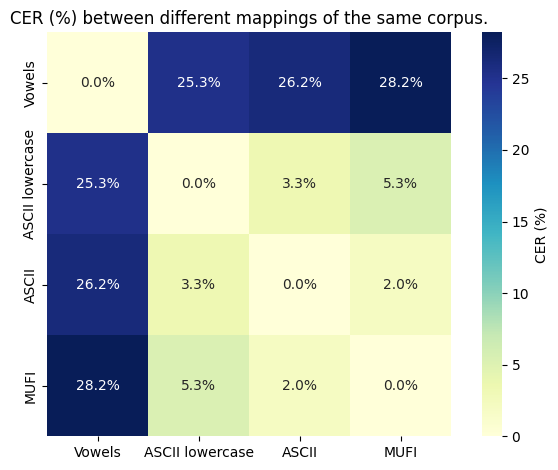

In [6]:
df = get_cer_table(corpus_str, mappers, mappernames)
annot = df.applymap(lambda x: f"{x:.1f}%")
#sns.heatmap(df)
sns.heatmap(df, annot=annot,fmt="", cmap="YlGnBu", square=True, cbar_kws={"label": "CER (%)"})
plt.title("CER (%) between different mappings of the same corpus.")
plt.tight_layout()
plt.savefig("corpus_mapping_cer_table.pdf")

In [7]:
def get_cer_ter_bysizes(corpus_str, mappers, mappernames, tokenizer_sizes):
    tknsz_mapname_to_ter_cer = {}
    for tokenizer_size in tokenizer_sizes:
        tokenizer = create_tokenizers(corpus_str, vocab_size=tokenizer_size)[0]
        for mapper, mapname in zip(mappers, mappernames):
            (correct, total), (str_same, str_total) = tokenization_distance(corpus_str, lambda x:x,  mapper, tokenizer)
            if total ==0:
                total=1
            if str_total == 0:
                str_total=1
            tknsz_mapname_to_ter_cer[(tokenizer_size, mapname)] = (correct/total), total, (str_same/str_total)
    return tknsz_mapname_to_ter_cer

tknsz_mapname_to_ter_cer = get_cer_ter_bysizes(corpus_str, mappers, mappernames, tokenizer_sizes=[200, 500, 750, 1000, 1500, 2000, 3000, 6000, 9000,  15000, 30000, 40000])




Tokens: 64.30% @1815219,  CER:30.16 @ 2946140
Tokens: 15.22% @1626116,  CER:7.07 @ 2946140
Tokens: 11.33% @1626116,  CER:3.73 @ 2946140
Tokens: 3.16% @1584432,  CER:1.70 @ 2946140



Tokens: 79.37% @1514184,  CER:30.16 @ 2946140
Tokens: 22.92% @1208877,  CER:7.07 @ 2946140
Tokens: 17.74% @1208888,  CER:3.73 @ 2946140
Tokens: 4.39% @1141400,  CER:1.70 @ 2946140



Tokens: 83.41% @1427474,  CER:30.16 @ 2946140
Tokens: 25.91% @1103564,  CER:7.07 @ 2946140
Tokens: 20.21% @1100857,  CER:3.73 @ 2946140
Tokens: 4.88% @1025760,  CER:1.70 @ 2946140



Tokens: 86.52% @1405253,  CER:30.16 @ 2946140
Tokens: 28.06% @1038140,  CER:7.07 @ 2946140
Tokens: 22.04% @1035434,  CER:3.73 @ 2946140
Tokens: 5.24% @954987,  CER:1.70 @ 2946140



Tokens: 88.81% @1337013,  CER:30.16 @ 2946140
Tokens: 30.65% @961468,  CER:7.07 @ 2946140
Tokens: 24.21% @958746,  CER:3.73 @ 2946140
Tokens: 5.73% @874240,  CER:1.70 @ 2946140



Tokens: 90.27% @1298469,  CER:30.16 @ 2946140
Tokens: 32.38% @913456,  CER:7.07 @ 2946

In [8]:
tknsz_mapper_to_error = {("CER", nam):tknsz_mapname_to_ter_cer[1000, nam][-1] for nam in mappernames}
tknsz_mapper_to_error.update({k:v[0] for k, v in tknsz_mapname_to_ter_cer.items()})
token_size = sorted([v[1] for v in tknsz_mapname_to_ter_cer.values()])
print(f"Token Sizes ranges {min(token_size)} {max(token_size)}" )
[m("HELLO WORLD È") for m in mappers]

Token Sizes ranges 591893 1815219


['halla warld *', 'hello world *', 'HELLO WORLD *', 'HELLO WORLD È']

/tmp/ipykernel_340320/3414022511.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels())


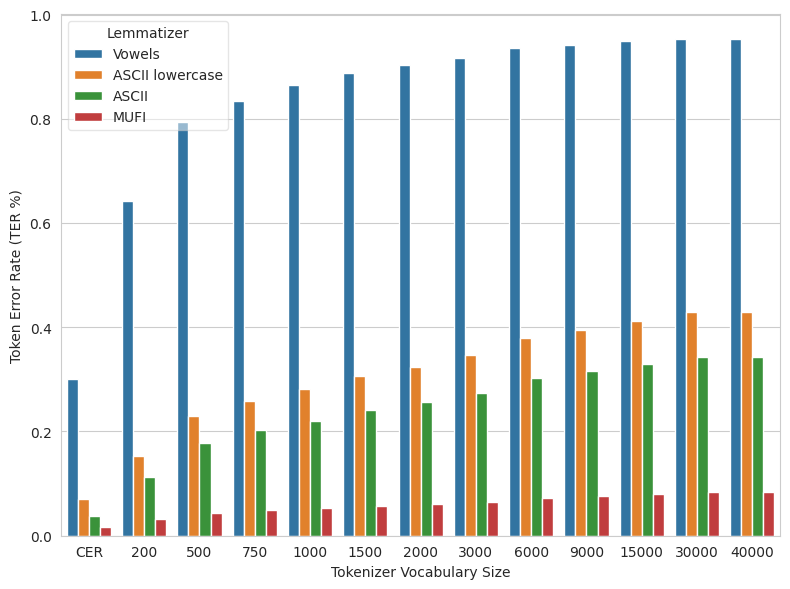

In [9]:
tknsz_mapper_to_error = {("CER", nam):tknsz_mapname_to_ter_cer[1000, nam][-1] for nam in mappernames}
tknsz_mapper_to_error.update({k:v[0] for k, v in tknsz_mapname_to_ter_cer.items()})

df = pd.DataFrame([
    {"Token Count": k[0], "Lemmatizer": k[1], "Value": v}
    for k, v in tknsz_mapper_to_error.items()
])

#df = df.sort_values(by="Lemmatizer", ascending=False)
#df = df.sort_values(by="Token Count", ascending=True)


plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
ax = sns.barplot(data=df, x="Token Count", y="Value", hue="Lemmatizer")

# Only group labels on x-axis
ax.set_xticklabels(ax.get_xticklabels())

# Transparent legend
legend = ax.legend(title='Lemmatizer')
frame = legend.get_frame()
frame.set_alpha(0.5)  # Set transparency

# Optional: Set axis labels
ax.set_ylabel("Token Error Rate (TER %)")
ax.set_xlabel("Tokenizer Vocabulary Size")

plt.tight_layout()
plt.savefig("vocab_size_by_mapper.pdf")
plt.show()

In [10]:
tokenizer = create_tokenizers(corpus_str, vocab_size=100)[0]
print(tokenizer.encode("Hello worlds").ids)
print(tokenizer.encode("Hello world").ids)




[40, 84, 96, 96, 82, 55, 82, 92, 96, 89, 85]
[40, 84, 96, 96, 82, 55, 82, 92, 96, 89]


In [11]:
#tokenizers = create_tokenizers(corpus_str, mappers, mappernames)
tokenizer = create_tokenizers(corpus_str, vocab_size=NBTOKENS)[0]

In [12]:
tkn_dm_onetkn, str_dm_onetkn = get_tokenization_dmat(corpus_str, mappers, tokenizer)

Tokens: 0.00% @1185395,  CER:0.00 @ 2946140
Tokens: 82.25% @1185421,  CER:25.55 @ 2946140
Tokens: 81.86% @1185421,  CER:26.43 @ 2946140
Tokens: 93.24% @1185406,  CER:28.46 @ 2946140
Tokens: 82.25% @1185421,  CER:25.55 @ 2946140
Tokens: 0.00% @774873,  CER:0.00 @ 2946140
Tokens: 8.41% @774873,  CER:3.34 @ 2946140
Tokens: 33.48% @774874,  CER:5.37 @ 2946140
Tokens: 81.86% @1185421,  CER:26.43 @ 2946140
Tokens: 8.41% @774873,  CER:3.34 @ 2946140
Tokens: 0.00% @772294,  CER:0.00 @ 2946140
Tokens: 25.16% @772295,  CER:2.03 @ 2946140
Tokens: 93.24% @1185406,  CER:28.46 @ 2946140
Tokens: 33.48% @774874,  CER:5.37 @ 2946140
Tokens: 25.16% @772295,  CER:2.03 @ 2946140
Tokens: 0.00% @639685,  CER:0.00 @ 2946140


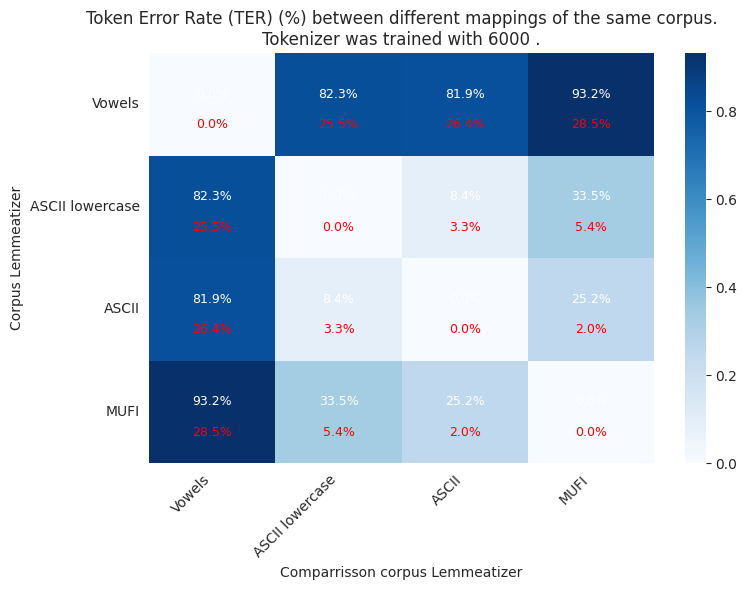

In [13]:
tkn_df = pd.DataFrame(tkn_dm_onetkn, index=mappernames, columns=mappernames)

# Plot heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(tkn_df, annot=False, fmt=".2f", cmap="Blues", cbar=True)

# Annotate each cell
for i in range(tkn_dm_onetkn.shape[0]):
    for j in range(tkn_dm_onetkn.shape[1]):
        tkn_val = f"{tkn_dm_onetkn[i, j]*100:.1f}%"
        str_val = f"{str_dm_onetkn[i, j]*100:.1f}%"
        
        ax.text(j + 0.5, i + 0.4, tkn_val, ha='center', va='center', color='white', fontsize=9)
        ax.text(j + 0.5, i + 0.7, str_val, ha='center', va='center', color='red', fontsize=9)

# Improve tick labels
ax.set_xticklabels(mappernames, rotation=45, ha='right')
ax.set_yticklabels(mappernames, rotation=0)
ax.set_ylabel("Corpus Lemmeatizer")
ax.set_xlabel("Comparrisson corpus Lemmeatizer")
#sns.heatmap(tkn_dm, annot=annot,fmt="", cmap="YlGnBu", square=True, cbar_kws={"label": "TER (%)"})
plt.title(f"Token Error Rate (TER) (%) between different mappings of the same corpus.\nTokenizer was trained with {NBTOKENS} .")
plt.tight_layout()
plt.savefig(f"corpus_mapping_cer_table_singletokenizer_{NBTOKENS}.pdf")

In [14]:
tokenizers = create_tokenizers(corpus_str, mappers, mappernames, vocab_size=NBTOKENS)
tkn_dm, str_dm = get_tokenization_dmat(corpus_str, mappers, tokenizers)













Tokens: 0.00% @700221,  CER:0.00 @ 2946140
Tokens: 78.68% @700221,  CER:25.55 @ 2946140
Tokens: 78.00% @700221,  CER:26.43 @ 2946140
Tokens: 92.89% @700221,  CER:28.46 @ 2946140
Tokens: 84.30% @1143489,  CER:25.55 @ 2946140
Tokens: 0.00% @736436,  CER:0.00 @ 2946140
Tokens: 8.79% @736436,  CER:3.34 @ 2946140
Tokens: 29.72% @736583,  CER:5.37 @ 2946140
Tokens: 83.87% @1143839,  CER:26.43 @ 2946140
Tokens: 8.83% @737467,  CER:3.34 @ 2946140
Tokens: 0.00% @734891,  CER:0.00 @ 2946140
Tokens: 20.97% @735042,  CER:2.03 @ 2946140
Tokens: 93.24% @1185406,  CER:28.46 @ 2946140
Tokens: 33.49% @774768,  CER:5.37 @ 2946140
Tokens: 25.16% @772189,  CER:2.03 @ 2946140
Tokens: 0.00% @639559,  CER:0.00 @ 2946140


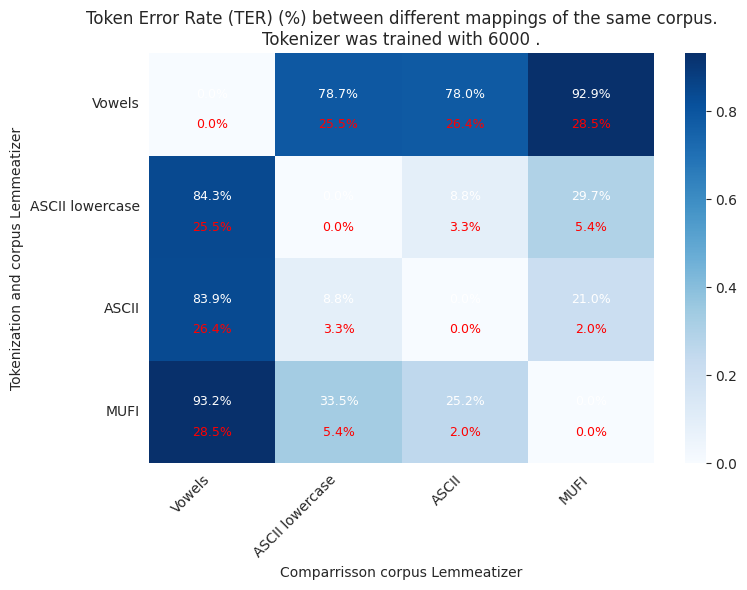

In [15]:
tkn_df = pd.DataFrame(tkn_dm, index=mappernames, columns=mappernames)

# Plot heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(tkn_df, annot=False, fmt=".2f", cmap="Blues", cbar=True)

# Annotate each cell
for i in range(tkn_dm.shape[0]):
    for j in range(tkn_dm.shape[1]):
        tkn_val = f"{tkn_dm[i, j]*100:.1f}%"
        str_val = f"{str_dm[i, j]*100:.1f}%"
        
        ax.text(j + 0.5, i + 0.4, tkn_val, ha='center', va='center', color='white', fontsize=9)
        ax.text(j + 0.5, i + 0.7, str_val, ha='center', va='center', color='red', fontsize=9)

# Improve tick labels
ax.set_xticklabels(mappernames, rotation=45, ha='right')
ax.set_yticklabels(mappernames, rotation=0)
ax.set_ylabel("Tokenization and corpus Lemmeatizer")
ax.set_xlabel("Comparrisson corpus Lemmeatizer")

#sns.heatmap(tkn_dm, annot=annot,fmt="", cmap="YlGnBu", square=True, cbar_kws={"label": "TER (%)"})
plt.title(f"Token Error Rate (TER) (%) between different mappings of the same corpus.\nTokenizer was trained with {NBTOKENS} .")
plt.tight_layout()
plt.savefig(f"corpus_mapping_cer_table_multitokenizer_{NBTOKENS}.pdf")